# A3: Three practical tools: TensorBoard, LIME, Keras Tuner

## About

In this assignment, you will gain hands-on experience with three practical tools. This assignment also includes several questions which require written responses (length: about a paragraph each). Please write your answers in this notebook in the text cells provided.

Starter code showing how to use TensorBoard.dev is provided at the end of this notebook.

## Submission instructions

To submit this assignment, please save your notebook (with output), and upload it to CourseWorks.

# Section 1: Run experiments and visualize your results using TensorBoard

Deep Learning is a new and developing field. Frequently, papers are published introducing new activation functions, weight initialization strategies,  optimizers, and layers. These papers often include results on large dataets (ImageNet), but whether the techniques they introduce will generalize to your datasets (which are often much smaller) remains unclear. The best way to determine that is by running an experiment.

## Swish

The current "default" activation function is ReLU (informally, our experience is that while it may not be optimal for all datasets, it is usually a reasonable choice). In the paper [Searching for Activation Functions](https://arxiv.org/abs/1710.05941), the authors propose a new activation function called "Swish", which they believe may become the default in the future. 

## Written Answers
Please answer the following questions with a clear and concice one paragraph response each.

## 1a) Why is ReLU activation prefered over Sigmoid?

 ReLU is generally the prefered activation function over Sigmoid for a number of reasons. One being that the ReLU function is less computaionally expensive as the sigmoid function. An additional advantage is that the ReLU function does not have the issue of the vanishing gradient seen with the sigmoid function. For the sigmoid function when the absolute value of the input increase the derivative of the function decreases. This phenomenon can lead to stagnation issues while attempting to compute gradient decent.

## 1b) What is the Vanishing Gradient problem? Specifically, when and why does it occur in a MLP?

As described above when training a MLP using backpropogation the weights of the network are updated based on the derivative of the error function which is calculated based upon the activation function of each neuron. The issue arrises when the partial derivative of the error function becomes very small due to the nature of the activation function. This causes the optimization process to become  stagnant. 


## Programming questions
Please answer the following questions by writing code in this notebook (in the cells provided below) and saving your output.

## 1c) Implement the Swish activation function using TensorFlow 2.1

Note: Swish is [available](https://www.tensorflow.org/api_docs/python/tf/keras/activations/swish) in tf-nightly. Do not use the built-in implemention. Instead, you should write a custom activation function (as if it was not yet available in the codebase). You do *not* need to extend TensorFlow to make your Swish implementation available everywhere (just write code to make it work in this notebook).

In [0]:
# TODO: your code here
# Feel free to add additional code cells if helpful

def swish(x):  
  return x*tf.keras.activations.sigmoid(x)


## 1d) Run an experiment to see whether Swish is helpful on a small dataset

- Choose a small datasets (e.g., CIFAR-10). 
- Train two NNs: One using ReLu activation, and one using your Swish implementation. 
- Visualize the learning curves for training & validation loss and accuracy using TensorBoard.dev (you can find starter code for TensorBoard.dev at the bottom of this notebook). 
- Fix the TensorFlow random seed before running these experiments, so your results are reproducibile (you can find a notebook on CourseWorks that demonstrates how to fix the seed).

Note: It may be difficult to see whether Swish is helpful with a small experiment like this, and it's likely that your learning curves will be noisy. You do not need to run a perfect experiment (the goal is for you to gain experience implementing a custom activation function, and to learn how to use TensorBoard).


In [5]:

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)


2.2.0-rc1


In [0]:
import numpy as np
import random
from tensorflow.keras.layers import Dense, Flatten 
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import datetime 
import os

random.seed(42) # not necessary, but may be helpful if you have other code
np.random.seed(42) # not necessary, but may be helpful if you have other code
tf.random.set_seed(42)

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Batch and shuffle the data
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train.astype('float32') / 255, y_train)).shuffle(60000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices(
    (x_test.astype('float32') / 255, y_test)).batch(32)

In [0]:
date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join("./tensorboard-logs/", date)
print("Writing logs to", log_dir)

Writing logs to ./tensorboard-logs/20200322-152636


In [0]:
## RELU
class MyDNN(Model):
  def __init__(self):
    super(MyDNN, self).__init__()
    self.flatten = Flatten(input_shape=(32, 32, 32, 3))
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(64, activation='relu')
    self.d3 = Dense(32, activation='relu')
    self.d4 = Dense(10, activation='softmax')

  def call(self, x):
    x = self.flatten(x)
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    # print(x)
    return self.d4(x)

model = MyDNN()

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_fn(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_fn(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)


train_writer = tf.summary.create_file_writer(os.path.join(log_dir, "Relu - train"))
test_writer = tf.summary.create_file_writer(os.path.join(log_dir, "Relu - test"))

EPOCHS = 100

for epoch in range(EPOCHS):
  
  for images, labels in train_ds:
    train_step(images, labels)
    
  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))
  
  with train_writer.as_default():
    tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)
    tf.summary.scalar('loss', train_loss.result(), step=epoch)

    # ====
    # Demo: show how to use histogram summaries
    # Create and log some random data
    # Useful if you're attemping the extra credit question
    # ====
    data = tf.random.normal((32, 100))
    tf.summary.histogram('random', 
                         data,
                         step=epoch, 
                         description='Your description')
    
  with test_writer.as_default():
    tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
    tf.summary.scalar('loss', test_loss.result(), step=epoch)
    
  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

Epoch 1, Loss: 1.8908886909484863, Accuracy: 31.536001205444336, Test Loss: 1.7378672361373901, Test Accuracy: 36.959999084472656
Epoch 2, Loss: 1.7204782962799072, Accuracy: 37.970001220703125, Test Loss: 1.6853394508361816, Test Accuracy: 39.82999801635742
Epoch 3, Loss: 1.648645043373108, Accuracy: 40.444000244140625, Test Loss: 1.6040765047073364, Test Accuracy: 42.13999938964844
Epoch 4, Loss: 1.5921355485916138, Accuracy: 42.75400161743164, Test Loss: 1.5848504304885864, Test Accuracy: 42.959999084472656
Epoch 5, Loss: 1.5578539371490479, Accuracy: 43.93199920654297, Test Loss: 1.5999211072921753, Test Accuracy: 43.0099983215332
Epoch 6, Loss: 1.530818223953247, Accuracy: 45.209999084472656, Test Loss: 1.5440140962600708, Test Accuracy: 44.459999084472656
Epoch 7, Loss: 1.502284288406372, Accuracy: 46.09000015258789, Test Loss: 1.5486111640930176, Test Accuracy: 44.130001068115234
Epoch 8, Loss: 1.4842950105667114, Accuracy: 46.79600143432617, Test Loss: 1.5453975200653076, Test 

In [0]:
## Swish
class MyDNN(Model):
  def __init__(self):
    super(MyDNN, self).__init__()
    self.flatten = Flatten(input_shape=(32, 32, 32, 3))
    self.d1 = Dense(128)
    self.d2 = Dense(64)
    self.d3 = Dense(32)

    self.d4 = Dense(10, activation='softmax')

  def call(self, x):
    # print(x)
    x = self.flatten(x)
    x = self.d1(x)
    x = swish(x)
    x = self.d2(x)
    x = swish(x)
    x = self.d3(x)
    x = swish(x)
    # print(x)
    return self.d4(x)

model = MyDNN()

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_fn(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_fn(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)


train_writer = tf.summary.create_file_writer(os.path.join(log_dir, "Swish - train"))
test_writer = tf.summary.create_file_writer(os.path.join(log_dir, "Swish - test"))

EPOCHS = 100

for epoch in range(EPOCHS):
  
  for images, labels in train_ds:
    train_step(images, labels)
    
  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))
  
  with train_writer.as_default():
    tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)
    tf.summary.scalar('loss', train_loss.result(), step=epoch)

    # ====
    # Demo: show how to use histogram summaries
    # Create and log some random data
    # Useful if you're attemping the extra credit question
    # ====
    data = tf.random.normal((32, 100))
    tf.summary.histogram('random', 
                         data,
                         step=epoch, 
                         description='Your description')
    
  with test_writer.as_default():
    tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
    tf.summary.scalar('loss', test_loss.result(), step=epoch)
    
  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

Epoch 1, Loss: 1.8574587106704712, Accuracy: 32.327999114990234, Test Loss: 1.715945839881897, Test Accuracy: 37.92000198364258
Epoch 2, Loss: 1.680107831954956, Accuracy: 39.40999984741211, Test Loss: 1.6222938299179077, Test Accuracy: 42.46999740600586
Epoch 3, Loss: 1.6075050830841064, Accuracy: 42.20600128173828, Test Loss: 1.5832891464233398, Test Accuracy: 43.15999984741211
Epoch 4, Loss: 1.5575790405273438, Accuracy: 43.906002044677734, Test Loss: 1.5492335557937622, Test Accuracy: 44.8900032043457
Epoch 5, Loss: 1.5250575542449951, Accuracy: 45.18199920654297, Test Loss: 1.5353549718856812, Test Accuracy: 45.34000015258789
Epoch 6, Loss: 1.4996708631515503, Accuracy: 46.08399963378906, Test Loss: 1.5398486852645874, Test Accuracy: 44.630001068115234
Epoch 7, Loss: 1.4780868291854858, Accuracy: 46.87800216674805, Test Loss: 1.5017510652542114, Test Accuracy: 47.150001525878906
Epoch 8, Loss: 1.4600143432617188, Accuracy: 47.59599685668945, Test Loss: 1.5162891149520874, Test Acc

In [0]:
!tensorboard dev upload --logdir "$log_dir"

Upload started and will continue reading any new data as it's added
to the logdir. To stop uploading, press Ctrl-C.
View your TensorBoard live at: https://tensorboard.dev/experiment/5TvWKdaFQy66M9P6ipN6kQ/

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/uploader/uploader_main.py", line 605, in execute
    uploader.start_uploading()
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/uploader/uploader.py", line 165, in start_uploading
    self._logdir_poll_rate_limiter.tick()
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/uploader/util.py", line 45, in tick
    self._time.sleep(wait_secs)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/main.py", line 66, in run_main
    app.run(tensorboard.main, flags_parser=t

## 1e) Include a brief written answer to the following questions:
- Did Swish help your NNs reach a higher validation accuracy? 
- Did it reduce the time (in terms of training epochs) needed to reach a certain accuracy?
- Please include the URLs showing the results of your experiments in TensorBoard.dev to justify your results.

# Experiment Results
https://tensorboard.dev/experiment/5TvWKdaFQy66M9P6ipN6kQ/

# Analysis

Although in general the 2 networks preformed relatively similarely, it can be seen that the network utelizing the swish activation functions achieved a slightly higher validation accuracy (about 49%) than the network utelizing relu activation functions (about 48%).

As for the time required to acieve these validation accuracy there is no noticable difference when the training noise is taken into account

# Section 2: Use LIME to explain an image classifier

Explaining and interpreting models is a new and increasingly important area of Deep Learning. In this section, you will gain experience using a recent (and relatively simple) technique called LIME.

## Written answers

## 2a) Read the paper [ConvNets and ImageNet Beyond Accuracy: Understanding Mistakes and Uncovering Biases](https://arxiv.org/abs/1711.11443) then answer the following two questions:
- Why would a model misclassify a professional sports player based on the color of their skin?
- What changes would you make to the training set to correct this behavior?

### Why would a model misclassify a professional sports player based on the color of their skin?

One hypothesis is that despite the balanced distribution of races in pictures labeled basketball, black persons are more represented in this class in comparison to the other classes.

### What changes would you make to the training set to correct this behavior?

Ensure that there is a balanced distribution of races in ALL of the individual subest of examples corresponding to ALL of the classes.


## Programming questions

## 2b) Read the paper ["Why Should I Trust You?": Explaining the Predictions of Any Classifier](https://arxiv.org/abs/1602.04938) then practice using LIME by adding code below to do the following:
- Install LIME
- Download an image from the web (using `!wget` or a similar utility).
- Classify your image using Inception-V3 (or another famous architecture, using weights pretrained on ImageNet).
- Display the top three predicted classes (e.g., baseball player) and confidence scores.
- Use LIME to provide evidence for and against each of the top three predictions (e.g., display the regions of an image that LIME found to correlate most strongly with and against the predicted class).

Save your output inside this notebook and include it with your submission.

In [0]:
!pip install lime

('wiz.jpg', <http.client.HTTPMessage at 0x7fef98ce76a0>)

In [10]:
base_model = tf.keras.applications.inception_v3.InceptionV3(
  include_top = True,
  weights = "imagenet"
)

96116736/96112376 [==============================] - 1s 0us/step



TOP 3 RESULTS
Predicted Label: basketball     Confidence Score: 0.13987404
Predicted Label: stage     Confidence Score: 0.085866675
Predicted Label: sax     Confidence Score: 0.033161443


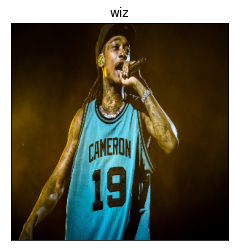

In [27]:
import os
import urllib.request
urllib.request.urlretrieve('https://image-cdn.hypb.st/https%3A%2F%2Fhypebeast.com%2Fimage%2F2020%2F01%2Fwiz-khalifa-real-rappers-rap-music-video-000.jpg?w=960&cbr=1&q=90&fit=max', 'wiz.jpg')

IMG_SIZE=299

import IPython.display as display
import matplotlib.pyplot as plt
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0  # normalize pixels to 0,1
  return img

def show(img, label):
  plt.imshow(img)
  plt.title(label)
  plt.xticks([])
  plt.yticks([])
  print()

img_path = 'wiz.jpg'
img = load_and_preprocess_image(img_path)
show(img,'wiz')
# print(img.shape)
img =tf.expand_dims(img, 0) 
result = base_model.predict(img)
print("TOP 3 RESULTS")
for x in decode_predictions(result)[0][:3]:
  print("Predicted Label: "+str(x[1])+"     Confidence Score: "+str(x[2]))
# print(decode_predictions(result)[0][:3])

In [31]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 1.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)

slim = tf.contrib.slim
import sys
sys.path.append('/Users/marcotcr/phd/tf-models/slim')
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

TensorFlow is already loaded. Please restart the runtime to change versions.
2.2.0-rc1


AttributeError: ignored

In [28]:
import os
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, _ = inception.inception_v3(processed_images, num_classes=1001, is_training=False)
probabilities = tf.nn.softmax(logits)

checkpoints_dir = '/Users/marcotcr/phd/tf-models/slim/pretrained'
init_fn = slim.assign_from_checkpoint_fn(
    os.path.join(checkpoints_dir, 'inception_v3.ckpt'),
    slim.get_model_variables('InceptionV3'))
init_fn(session)

NameError: ignored

**Optional**

If you like to learn about another promising approach to explaining NNs, you can read the paper [Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365).

# Section 3: Use Keras Tuner to optimize a small model


## Written answers

## 3a) When and why might Grid Search be less effective than Random Search when searching for useful hyperparameters for a Deep Learning model?


### TODO: your answer here

## Programming questions

**3b) Add one or more code cells below in which you complete the following:**
- Install Keras Tuner
- Write a CNN to classify images from CIFAR-10 
- Use Keras Tuner to search for at least three optimal hyperpameters for your model (eg, number of layers, number of filters per layer, dropout rate, etc)

Save your output in this notebook.


In [0]:
# TODO: your code here
# You may add additional code cells if helpful

## 3c) In the text cell below, brielfy answer the following questions:
- What were the optimal hyperparmeters you found?
- Do they make sense (e.g., are they similar to parameters you might have picked yourself?)


### TODO: your answer here

---

## Starter code for TensorBoard
The following code shows how to use [TensorBoard](https://www.tensorflow.org/tensorboard) to display the results from an experiment comparing two learning curves. Please note, there are three ways to use TensorBoard. 
- You may install TensorBoard locally on your laptop
- You can run TensorBoard inside Colab (currently buggy)
- You can use TensorBoard.dev (this is the approach you should use for this assignment). 

In [0]:
%tensorflow_version 2.x

In [0]:
!pip install -U tensorboard

In [0]:
import tensorflow as tf

**Caution**. The following cell will delete any existing TensorBoard logs. If you're running this on your local machine, please be careful executing it.

In [0]:
!rm -rf ./tensorboard-logs/ # Clear any logs from previous runs

Import a dataset

In [0]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 0s 0us/step


## First style
The following code shows how to use TensorBoard with ```model.fit```.

In [0]:
from tensorflow.keras.layers import Dense, Flatten

def create_model():
  model = tf.keras.models.Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='softmax'),
  ])
  return model

Create a logs directory

In [0]:
import datetime 
import os
date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join("./tensorboard-logs/", date)
print("Writing logs to", log_dir)

### Run an experiment
The name of the experiment is given by the path of the logs directory (here, "exp1"). You'll want to use something more descriptive in your work (e.g., "swish-cifar-10").

In [0]:
from tensorflow.keras.optimizers import SGD

model = create_model() 
opt = SGD(learning_rate=0.001, momentum=0.0, nesterov=False) 
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

exp_dir = os.path.join(log_dir, "exp1")

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=exp_dir)

model.fit(x_train,
          y_train,
          epochs=10, 
          validation_data=(x_test, y_test), 
          callbacks=[tb_callback])

### Run a second experiment
Let's train another model, this time saving results to "exp2". Later, we'll be able to compare the learning curves of these experiments in TensorBoard.

In [0]:
model = create_model() 
opt = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

exp_dir = os.path.join(log_dir, "exp2")

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=exp_dir)

model.fit(x_train,
          y_train,
          epochs=10, 
          validation_data=(x_test, y_test), 
          callbacks=[tb_callback])

### Upload the logs to TensorBoard.dev, and compare the results
TensorBoard.dev is a hosted version of TensorBoard (see http://tensorboard.dev/ for details).

In [0]:
!tensorboard dev upload --logdir "$log_dir"

## Second style
Showing how to use TensorBoard with a Subclassed model and a GradientTape

Prepre the dataset

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
train_ds = train_ds.shuffle(60000).batch(32)
test_ds = test_ds.batch(32)

Define a simple model

In [0]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.flatten = Flatten(input_shape=(28, 28))
    self.d1 = Dense(10, activation='softmax')

  def call(self, x):
    x = self.flatten(x)
    return self.d1(x)

model = MyModel()

In [0]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [0]:
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

Training and testing routines

In [0]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_fn(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_fn(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

Prepare log writers (previously, these were handled by the callback)

In [0]:
date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join("./tensorboard-logs/", date)
print("Writing logs to", log_dir)

train_writer = tf.summary.create_file_writer(os.path.join(log_dir, "train"))
test_writer = tf.summary.create_file_writer(os.path.join(log_dir, "test"))

Writing logs to ./tensorboard-logs/20200321-152917


Train and log summaries

In [0]:
EPOCHS = 10

for epoch in range(EPOCHS):
  
  for images, labels in train_ds:
    train_step(images, labels)
    
  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))
  
  with train_writer.as_default():
    tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)
    tf.summary.scalar('loss', train_loss.result(), step=epoch)

    # ====
    # Demo: show how to use histogram summaries
    # Create and log some random data
    # Useful if you're attemping the extra credit question
    # ====
    data = tf.random.normal((32, 100))
    tf.summary.histogram('random', 
                         data,
                         step=epoch, 
                         description='Your description')
    
  with test_writer.as_default():
    tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
    tf.summary.scalar('loss', test_loss.result(), step=epoch)
    
  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

Epoch 1, Loss: 0.4738991856575012, Accuracy: 87.65833282470703, Test Loss: 0.30589091777801514, Test Accuracy: 91.52999877929688
Epoch 2, Loss: 0.30400350689888, Accuracy: 91.5816650390625, Test Loss: 0.28006136417388916, Test Accuracy: 92.25
Epoch 3, Loss: 0.2830759882926941, Accuracy: 92.10166931152344, Test Loss: 0.27733173966407776, Test Accuracy: 92.29999542236328
Epoch 4, Loss: 0.2731097638607025, Accuracy: 92.36000061035156, Test Loss: 0.27061912417411804, Test Accuracy: 92.44999694824219
Epoch 5, Loss: 0.2666522264480591, Accuracy: 92.5633316040039, Test Loss: 0.2657223045825958, Test Accuracy: 92.69999694824219
Epoch 6, Loss: 0.26179182529449463, Accuracy: 92.6933364868164, Test Loss: 0.26932454109191895, Test Accuracy: 92.45999908447266
Epoch 7, Loss: 0.2584364116191864, Accuracy: 92.84666442871094, Test Loss: 0.26669907569885254, Test Accuracy: 92.69000244140625
Epoch 8, Loss: 0.2554880678653717, Accuracy: 92.86833190917969, Test Loss: 0.2611234486103058, Test Accuracy: 92.8

### Upload the logs to TensorBoard.dev

In [0]:
!tensorboard dev upload --logdir "$log_dir"